In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [32]:
def NGD_TK_AS(T, epsilon, omegastar, deltastar, tau_y, Bmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):50]

In [33]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Load Data

In [34]:
dt = 0.01
cn = 19

file_list = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=0.5_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=1_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=1.5_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=2_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=3_20-Jul-2021_0']
contrast_list = [5, 10, 15, 20, 30]
x_list = []
T_list = []
rstate_list = []
for file in file_list:
    annots = loadmat(file, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect') / dt
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    print(np.std(x)/4E4)
    # x = (x -np.mean(x))/np.std(x)
    T = np.arange(len(x)+1)*dt
    rstate,_ = np.histogram(annots['Spikes'][cn-1]-TimeStamps[0], T)
    rstate_list.append( rstate.copy() )
    x_list.append( x.copy() )
    T_list.append( T.copy() )

0.49115740987722317
0.9872355963536171
1.4731203982414158
1.962898533370301
2.934936120653217


(0.0, 1.0)

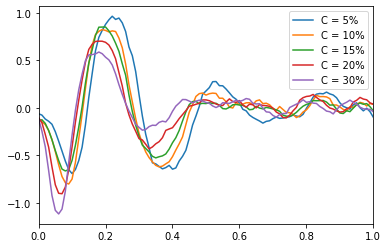

In [35]:
TKaxis = np.arange(101)*dt
TK_list = []
for i in range(len(x_list)):
    rstate = rstate_list[i]
    x = x_list[i]
    x = (x -np.mean(x))/np.std(x)
    TK = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
    TK = TK[int(len(TK)/2):int(len(TK)/2-1/dt)-1:-1]
    plt.plot(TKaxis, TK, label = 'C = '+str(contrast_list[i])+'%')
    TK_list.append( TK.copy() )
plt.legend(loc = 'best')
plt.xlim(0, 1)

Text(0.5, 1.0, 'group delay')

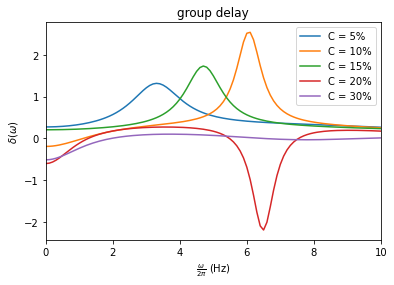

In [36]:
df = 0.1
faxis = np.arange(-20,20,df)
for i in range(len(x_list)):
    F_TK = np.sum(TK_list[i][np.newaxis,:]*np.exp(-1j*TKaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
    Phi = np.angle(F_TK)
    delta = -angular_gradient(Phi)/df
    plt.plot(faxis, delta, label = 'C = '+str(contrast_list[i])+'%')
plt.legend(loc = 'best')
plt.ylabel(r'$\delta(\omega)$')
plt.xlabel(r'$\frac{\omega}{2\pi}$ (Hz)')
plt.xlim([0,10])
plt.title('group delay')

# Separate fit

(0.0, 1.0)

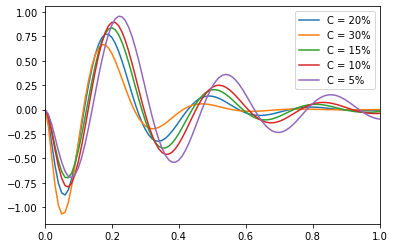

In [37]:
name_list  = ['epsilon', 'omegastar', 'deltastar', 'tau_y', 'Bmp' ]
initials   = [5        , 20         , 0.         , 0.03   , 2     ]
ibounds_min = [0        , 0          , -np.pi     , 0      , 0     ]
ibounds_max = [np.inf   , np.inf     ,  np.pi     , 0.5    , np.inf]

para_2dlist = [0]*len(x_list)
fitTK_list = [0]*len(x_list)

bounds_min = ibounds_min.copy()
bounds_max = ibounds_max.copy()
for i in [3,4,2,1,0]:
# for i in range(len(x_list)):
    popt,_ = curve_fit(NGD_TK_AS, TKaxis , TK_list[i], p0= initials, bounds = (bounds_min,bounds_max) )
    initials = popt
    # bounds_min = popt-1E-7
    # bounds_max = popt+1E-7
    # # chose which parameters to free
    # for j in [0,1,2,3]:
    #     bounds_min[j] = ibounds_min[j]
    #     bounds_max[j] = ibounds_max[j]
    fitTK = NGD_TK_AS(TKaxis, *popt)
    plt.plot(TKaxis, fitTK, label = 'C = '+str(contrast_list[i])+'%')
    fitTK_list[i] = fitTK.copy() 
    para_2dlist[i] = popt.copy()
plt.legend(loc = 'best')
plt.xlim(0, 1)

Text(0.5, 1.0, 'group delay')

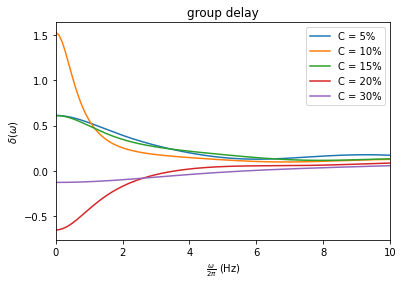

In [38]:
df = 0.1
faxis = np.arange(-20,20,df)
for i in range(len(x_list)):
    F_TK = np.sum(fitTK_list[i][np.newaxis,:]*np.exp(-1j*TKaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
    Phi = np.angle(F_TK)
    delta = -angular_gradient(Phi)/df
    plt.plot(faxis, delta, label = 'C = '+str(contrast_list[i])+'%')
plt.legend(loc = 'best')
plt.ylabel(r'$\delta(\omega)$')
plt.xlabel(r'$\frac{\omega}{2\pi}$ (Hz)')
plt.xlim([0,10])
plt.title('group delay')

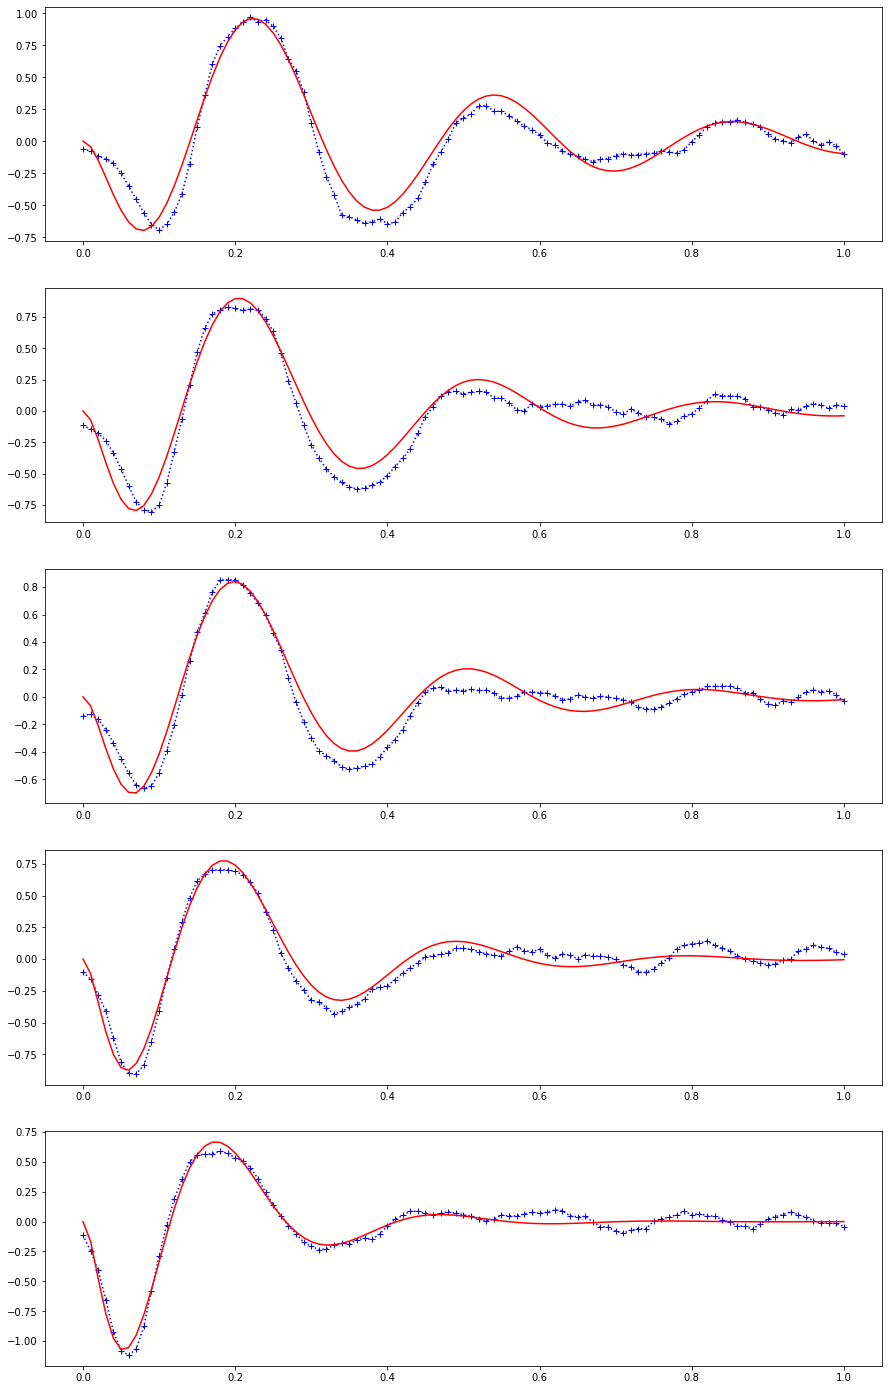

In [39]:
fig, ax = plt.subplots(len(x_list),1)
for i in range(len(x_list)):
    ax[i].plot(TKaxis, TK_list[i], 'b+:')
    ax[i].plot(TKaxis, fitTK_list[i], 'r-')
    # ax[i][1].plot(faxis, delta)
fig.set_size_inches( 15, 5*len(x_list) )

In [40]:
ASpara_DF = pd.DataFrame(para_2dlist, index = contrast_list, columns = name_list)
ASpara_DF

,epsilon,omegastar,deltastar,tau_y,Bmp
5,2.739046,20.088066,0.242166,0.054134,2.956640
10,3.921453,20.166848,0.226264,0.038097,2.503043
15,4.379838,20.755230,0.293818,0.039682,2.499848
20,5.568762,20.698866,0.208223,0.027671,2.264233
30,8.201447,21.479090,0.161868,0.024555,2.677589


In [41]:
DEpara_DF = pd.DataFrame(np.ones((len(contrast_list), 6)), index = contrast_list, columns = ['m', 'n', 'alpha', 'beta', 'g', 'tau_y'])
DEpara_DF['m'] = ASpara_DF['Bmp']
DEpara_DF['tau_y'] = ASpara_DF['tau_y']
DEpara_DF['alpha'] = ASpara_DF['epsilon']+np.tan(ASpara_DF['deltastar'])*ASpara_DF['omegastar']
DEpara_DF['beta'] = ASpara_DF['epsilon']*2-DEpara_DF['alpha']
DEpara_DF['g'] = ASpara_DF['omegastar']**2+((DEpara_DF['alpha']-DEpara_DF['beta'])**2)/4

In [42]:
DEpara_DF

,m,n,alpha,beta,g,tau_y
5,2.956640,1.0,7.701066,-2.222973,428.152018,0.054134
10,2.503043,1.0,8.563993,-0.721086,428.254941,0.038097
15,2.499848,1.0,10.659864,-1.900188,470.218313,0.039682
20,2.264233,1.0,9.942121,1.195404,447.569319,0.027671
30,2.677589,1.0,11.708909,4.693985,473.653607,0.024555


In [44]:
1/np.exp(1)

0.36787944117144233